In [40]:
#based on: https://www.kaggle.com/code/monkira/brain-mri-segmentation-using-unet-keras/notebook

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#plt.style.use("ggplot")

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from keras import Input
from keras.models import Model, load_model, save_model
from keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, \
    MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

from PIL import Image

In [41]:
# Set Parameters, Import Data
im_width = 256
im_height = 256

mask_files = []
train_files = []
mask_files_with_empty = glob('/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files_with_empty:
    im = Image.open(i)
    if im.getbbox():
        mask_files.append(i)
        train_files.append(i.replace('_mask', ''))
        im = Image.open(i.replace('_mask', ''))

['lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_14.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_15.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_16.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_17.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_18.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4942_19970222\\TCGA_CS_4942_19970222_10.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4942_19970222\\TCGA_CS_4942_19970222_11.tif']
['lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11_mask.tif', 'lgg-mri-segmentation/kaggle_3m\\TCG

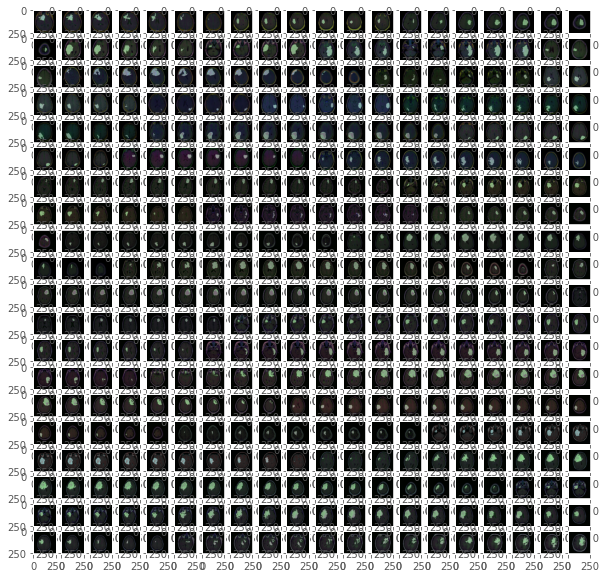

In [37]:
# plot some samples
fig = plt.figure(figsize=(10, 10))
for i in range(4):
    fig.add_subplot(1, 4, i+1)
    img_path = train_files[i]
    msk_path = mask_files[i]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    msk = cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk, alpha=0.4)
    plt.axis('off')
plt.show()

In [4]:
#Create data frame and split data on train set, validation set and test set

df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

#Data genertator, data augmentation and adjust data

# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
                    image_color_mode="rgb",
                    mask_color_mode="grayscale",
                    image_save_prefix="image",
                    mask_save_prefix="mask",
                    save_to_dir=None,
                    target_size=(256, 256),
                    seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="filename",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        #adjust data for training
        img = img / 255
        mask = mask / 255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        yield (img, mask)

(2828, 2)
(708, 2)
(393, 2)


In [5]:
#Define loss function & metrics

smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

#define UNET - https://arxiv.org/abs/1505.04597
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])


In [6]:
model = unet(input_size=(im_height, im_width, 3))

#lets see the model
model.summary()

#Training!
EPOCHS = 32
BATCH_SIZE = 32
learning_rate = 1e-4

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                            train_generator_args,
                            target_size=(im_height, im_width))

test_gener = train_generator(df_val, BATCH_SIZE,
                             dict(),
                             target_size=(im_height, im_width))

model = unet(input_size=(im_height, im_width, 3))

decay_rate = learning_rate / EPOCHS
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

#Figure out how to save and utilize History later.
print(len(df_train))
print(len(df_val))
history = model.fit(train_gen,
                    steps_per_epoch= len(df_train) / (8 * BATCH_SIZE),
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=test_gener,
                    validation_steps= len(df_val) / (8 * BATCH_SIZE)
)

import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = history.history
# Save it as a json file
json.dump(history_dict, open('history_dict.json', 'w'))


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

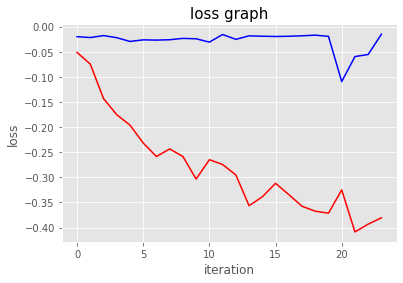

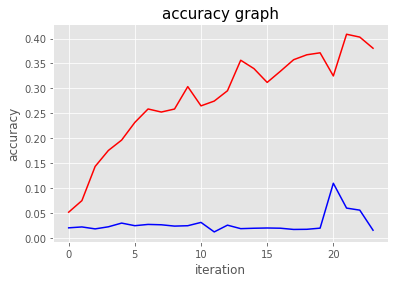

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 214s 17s/step - loss: -0.0660 - binary_accuracy: 0.9927 - iou: 0.0376 - dice_coef: 0.0706
Test lost:  -0.06597445160150528
Test IOU:  0.9926548004150391
Test Dice Coefficent:  0.03757164254784584


In [7]:
# load model

path = r'unet_brain_mri_seg.hdf5'

smooth=100

#Dice Loss - widely used metric in computer vision community to calculate the similarity between two images
def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    return((2* K.sum(y_truef* y_predf) + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


#check out the loss & accuracy
a = json.load(open('history_dict.json', 'r'))

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show() 


model = load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])


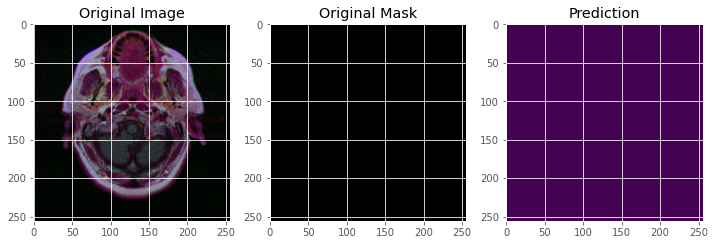

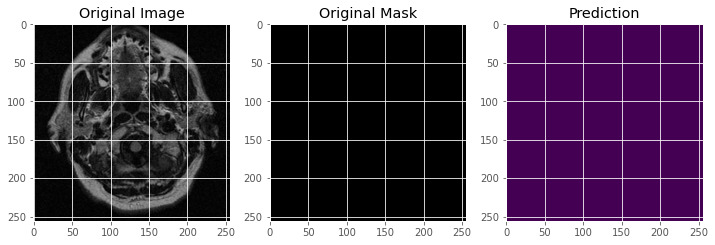

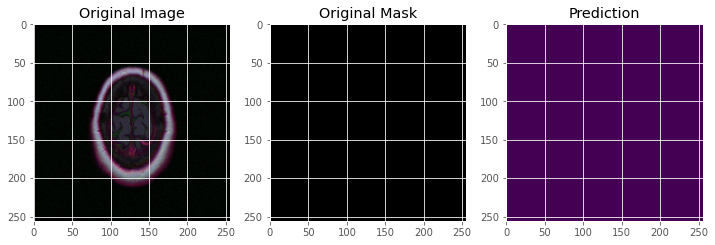

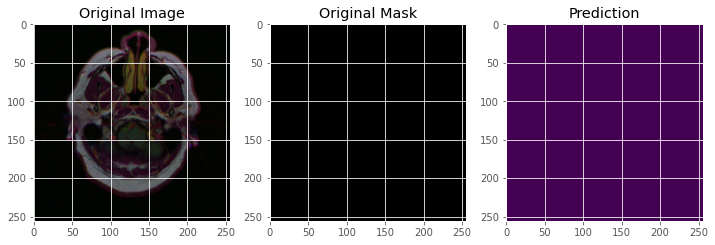

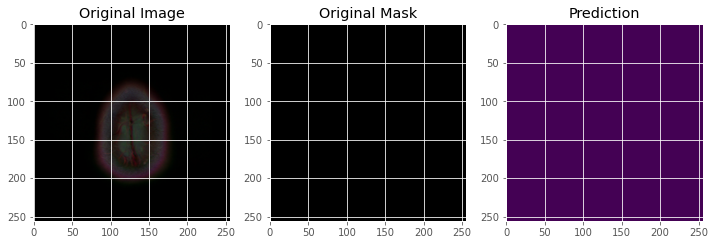

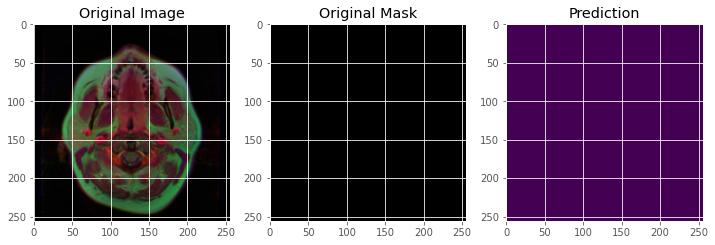

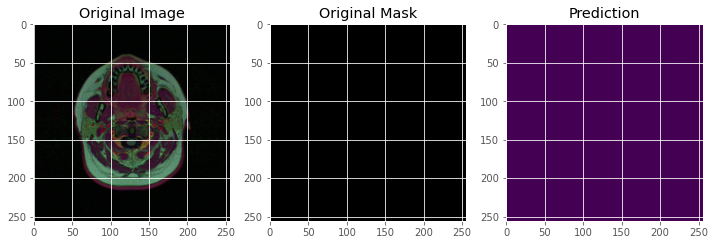

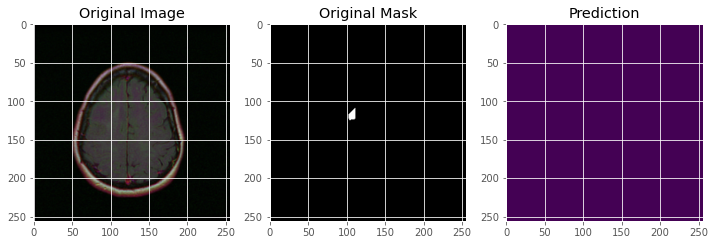

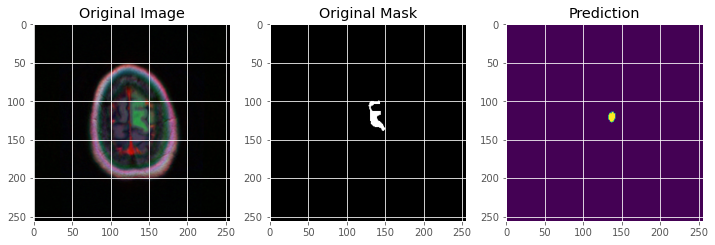

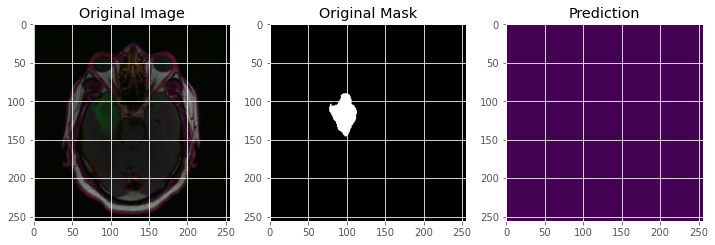

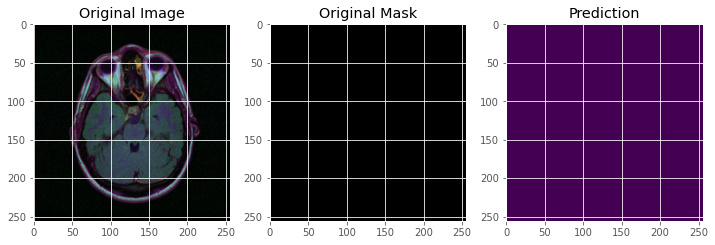

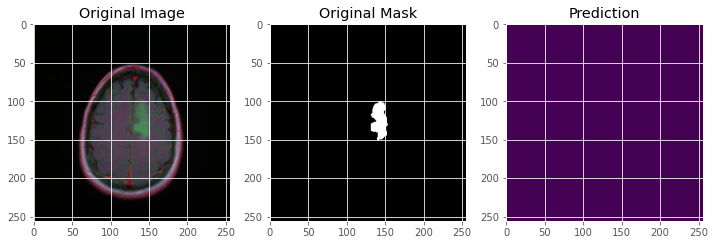

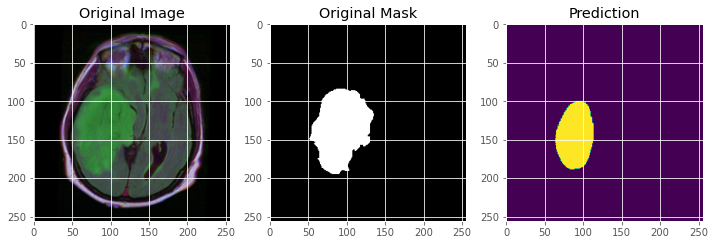

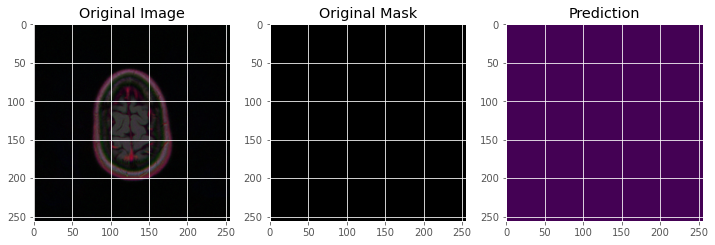

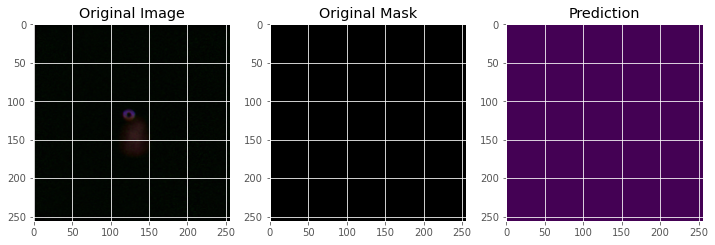

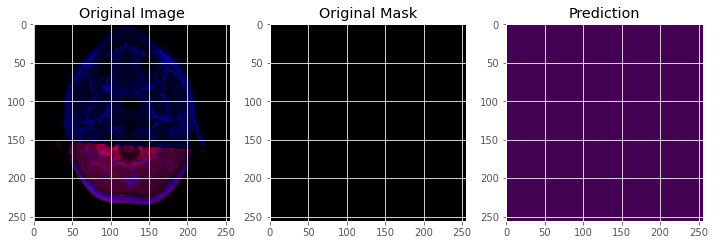

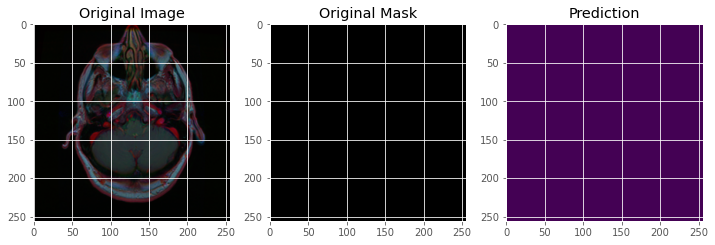

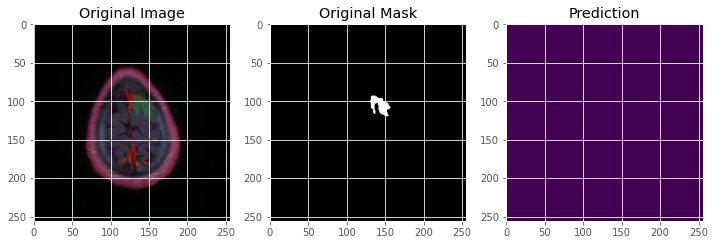

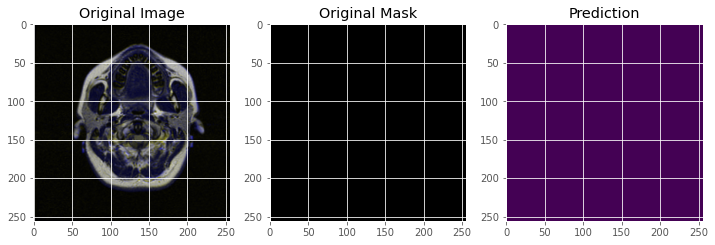

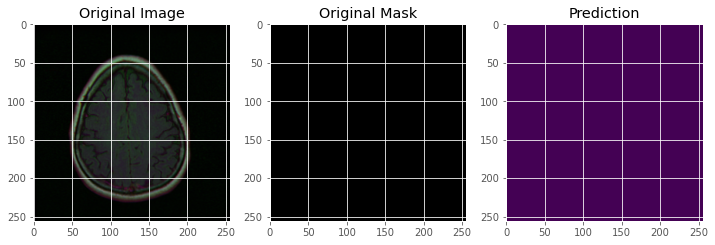

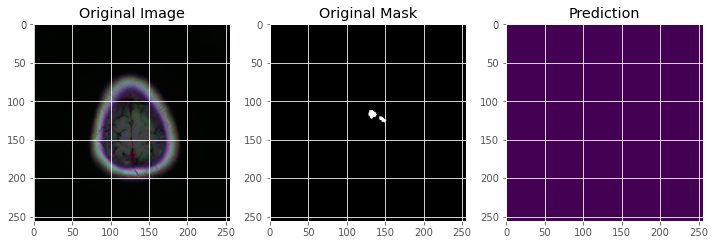

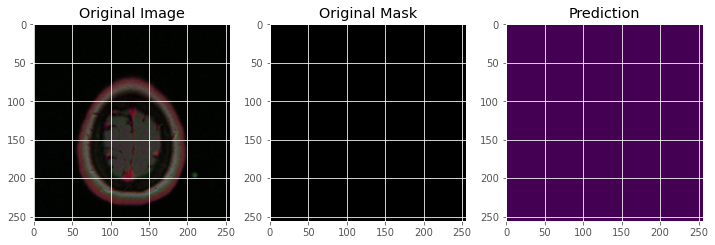

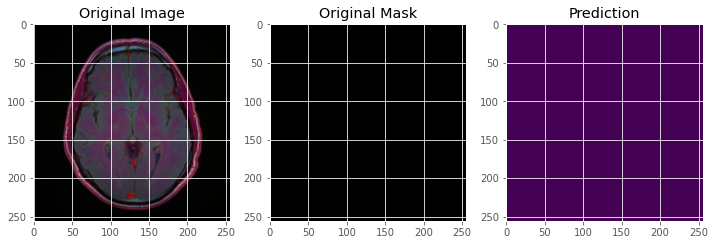

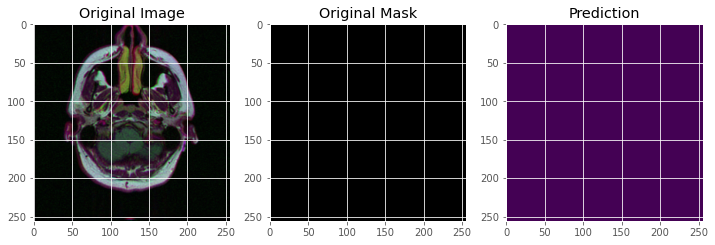

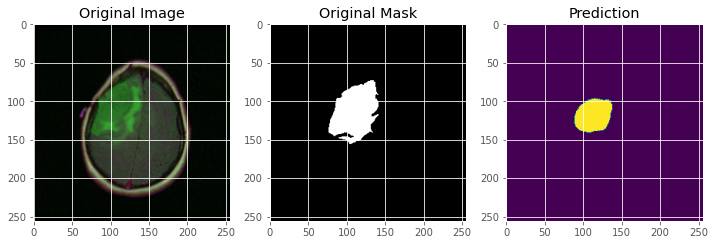

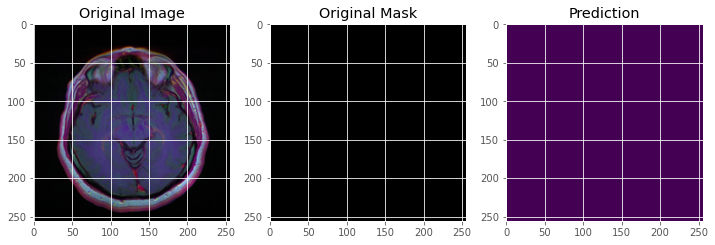

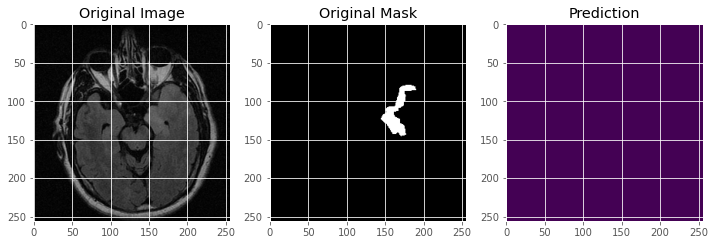

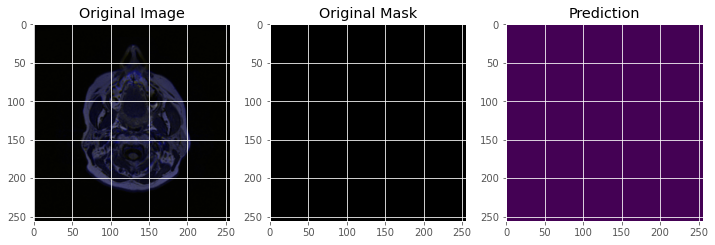

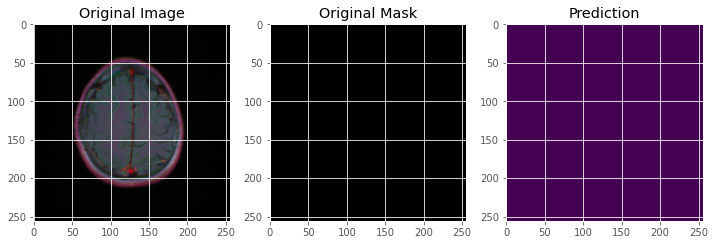

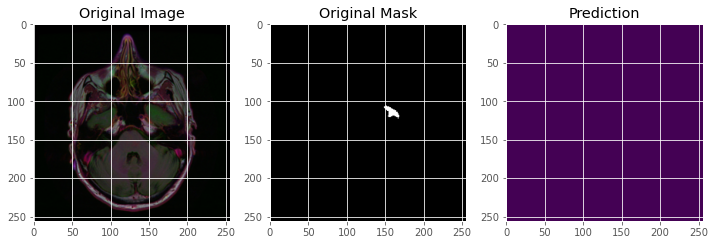

In [38]:
#Show 10 examples

for i in range(10):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

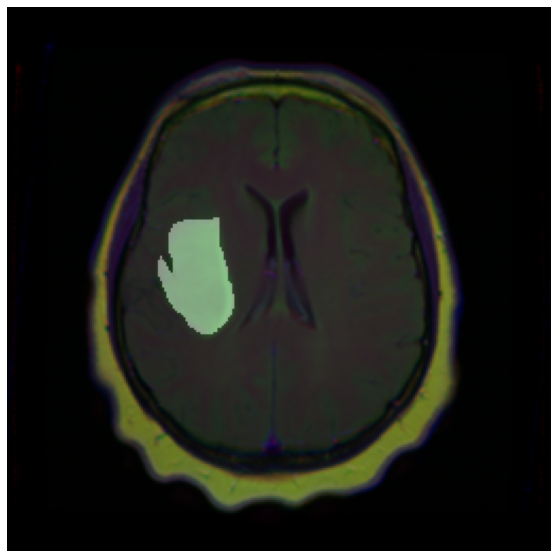

In [9]:
'''
#now import an image
inputImagePath = r'myBrainScan.tif'
mask_file = glob(inputImagePath)

# plot the image
rows, cols = 1, 1
fig = plt.figure(figsize=(10, 10))
for i in range(1, rows * cols + 1):
    img = cv2.imread(inputImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.grid(visible=None)
    plt.imshow(img)
    plt.imshow(msk, alpha=0.4)
plt.show()
'''

[[[[0.07087356]
   [0.06050307]
   [0.0447726 ]
   ...
   [0.05840117]
   [0.04931134]
   [0.05234024]]

  [[0.04978526]
   [0.04985318]
   [0.0436748 ]
   ...
   [0.03756317]
   [0.04807717]
   [0.0455308 ]]

  [[0.04074973]
   [0.03572425]
   [0.03200322]
   ...
   [0.03653511]
   [0.03099608]
   [0.03777969]]

  ...

  [[0.03914407]
   [0.04709589]
   [0.03745407]
   ...
   [0.03719291]
   [0.04548106]
   [0.03788114]]

  [[0.06005424]
   [0.039352  ]
   [0.03214759]
   ...
   [0.03671378]
   [0.03360906]
   [0.04463333]]

  [[0.09216768]
   [0.06880486]
   [0.04414853]
   ...
   [0.05165052]
   [0.04866597]
   [0.04928449]]]]


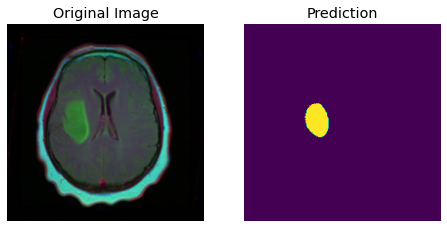

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

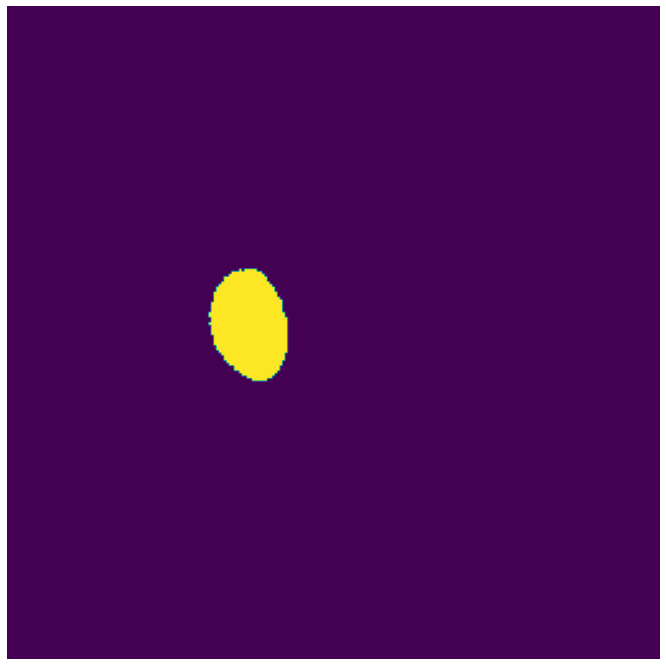

<Figure size 432x288 with 0 Axes>

In [10]:
'''
model = load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
inputImagePath = r'myBrainScan.tif'

img = cv2.imread(inputImagePath)
img = cv2.resize(img ,(im_height, im_width))
img = img / 255
img = img[np.newaxis, :, :, :]
pred=model.predict(img)
print(pred)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#pred = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(np.squeeze(img))
plt.title('Original Image')
plt.axis('off')
plt.grid(visible=None)
plt.subplot(1,3,2)
plt.imshow(np.squeeze(pred) > .5)
plt.title('Prediction')
plt.axis('off')
plt.grid(visible=None)
plt.show()
plt.savefig("PredictionComparison.png")

plt.figure(2)
plt.figure(figsize=(12,12))
plt.imshow(np.squeeze(pred) > .5)
plt.axis('off')
plt.grid(visible=None)
plt.show()
plt.savefig("Prediction.png")
'''
